# Question 2:  K-Nearest Neighbors

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

## Loading dataset and unique seed

In [3]:
df  = pd.read_csv('student_dataset.csv')
username = "reddy.bathula"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)

In [4]:
df

,gender,major,program,GPA
0,Male,B.Tech,CSE,7.739759
1,Female,B.Tech,CSE,6.214287
2,Other,B.Tech,ECE,6.817714
3,Male,B.Tech,ECE,5.694028
4,Female,PhD,ECE,8.193144
...,...,...,...,...
9995,Male,B.Tech,ECE,5.513188
9996,Female,MS,ECE,8.461818
9997,Male,MS,CSE,7.075341
9998,Male,PhD,CSE,8.248410


## PerFeatureTransformer

In [5]:
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        self.transformers = {}
        self.feature_types = {}
        
    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """
        Fits transformers for each feature based on the given type.
        Parameters:
            df: The dataframe containing features to be transformed.
            params: A dictionary mapping feature name to transformation type,
                   e.g., {"GPA": "standard", "major": "ordinal", "program": "onehot"}.
        """
        self.feature_types = params
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue
                
            if transform_type == "standard":
                scaler = StandardScaler()
                scaler.fit(df[[feature]])
                self.transformers[feature] = scaler
                
            elif transform_type == "ordinal":
                encoder = OrdinalEncoder()
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
            elif transform_type == "onehot":
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Applies the fitted transformers to the corresponding features and returns a NumPy array."""
        transformed_features = []
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue

            transformer = self.transformers[feature]
            transformed = transformer.transform(df[[feature]])
      
            if len(transformed.shape) == 2 and transformed.shape[1] > 1:
                transformed_features.append(transformed)
            else:
                transformed_features.append(transformed.reshape(-1, 1))
                
        return np.concatenate(transformed_features, axis=1)
    
    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """Fits and transforms all features in one step using the given transformation parameters."""
        self.fit(df, params)
        return self.transform(df)

## KNNGenderPredictor

In [6]:
class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str):
        """Initializes the predictor with the full student dataset. Use the username for plots."""
        self.df = student_df
        self.username = username
        self.feature_transformer = PerFeatureTransformer()
        self.train_df = None
        self.val_df = None
        self.test_df = None
        
    def _watermark(self, ax):
        """Username in the plots"""
        ax.text(
            0.95, 0.95, self.username,
            ha='right', va='top',
            transform=ax.transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        
    def train_val_test_split(self, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Split dataset into train, validation, and test sets."""
        
        train_val, test = train_test_split(self.df, test_size=test_size, random_state=seed)
        val_size_adjusted = val_size / (1 - test_size)
        train, val = train_test_split(train_val, test_size=val_size_adjusted, random_state=seed)
        # , stratify=self.df['gender']

        self.train_df = train.reset_index(drop=True)
        self.val_df = val.reset_index(drop=True)
        self.test_df = test.reset_index(drop=True)
        
        print(f"Dataset split:")
        print(f"Train: {len(self.train_df)} samples")
        print(f"Validation: {len(self.val_df)} samples")
        print(f"Test: {len(self.test_df)} samples")
        return self.train_df, self.val_df, self.test_df
    
    def get_feature_matrix_and_labels(self, df: pd.DataFrame, features: list[str]) -> tuple[np.ndarray, np.ndarray]:
        """
        Extract selected features and gender labels from the DataFrame.
        Applies encoding to categorical variables and normalizes numeric features.
        Do not fit encoders or scalers on test data. Only transform using previously fitted ones.
        """
        feature_df = df[features].copy()
        transform_params = {}
        for feature in features:
            if feature == 'GPA':
                transform_params[feature] = 'standard'
            elif feature in ['major', 'program']:
                transform_params[feature] = 'onehot'

        if hasattr(self.feature_transformer, 'transformers') and self.feature_transformer.transformers:
            X = self.feature_transformer.transform(feature_df)
        else:
            X = self.feature_transformer.fit_transform(feature_df, transform_params)
        
        if not hasattr(self, 'label_encoder'):
            self.label_encoder = LabelEncoder()
            y = self.label_encoder.fit_transform(df['gender'])
        else:
            y = self.label_encoder.transform(df['gender'])
        return X, y
    
    def get_knn_accuracy_vs_k(self, k_values: list[int], distance: str = "euclidean") -> list[float]:
        """Calculates accuracy scores for various k values on the validation set."""
        features = ['GPA', 'major', 'program']
        X_train, y_train = self.get_feature_matrix_and_labels(self.train_df, features)
        X_val, y_val = self.get_feature_matrix_and_labels(self.val_df, features)
        accuracies = []
        
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            accuracies.append(accuracy)
        return accuracies
    
    def plot_knn_accuracy_vs_k(self, k_values: list[int], distance: str = "euclidean") -> tuple[int, float]:
        """Plots accuracy scores against k values on the validation set."""
        accuracies = self.get_knn_accuracy_vs_k(k_values, distance)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(k_values, accuracies, 'bo-', linewidth=2, markersize=8)
        ax.set_xlabel('k (Number of Neighbors)')
        ax.set_ylabel('Validation Accuracy')
        ax.set_title(f'k-NN Accuracy vs k ({distance.capitalize()} Distance)')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(k_values)

        best_k_idx = np.argmax(accuracies)
        best_k = k_values[best_k_idx]
        best_acc = accuracies[best_k_idx]
        ax.plot(best_k, best_acc, 'ro', markersize=12, alpha=0.7)
        ax.annotate(f'Best k={best_k}\\nAcc={best_acc:.3f}', 
                   xy=(best_k, best_acc), xytext=(10, 10), 
                   textcoords='offset points', fontsize=12,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        self._watermark(ax)
        plt.tight_layout()
        plt.show()
        return best_k, best_acc
    
    def get_knn_f1_heatmap(self, k_values: list[int], distances: list[str]) -> pd.DataFrame:
        """Returns a dataframe with the f1-score for each combination on the validation set"""
        features = ['GPA', 'major', 'program']
        X_train, y_train = self.get_feature_matrix_and_labels(self.train_df, features)
        X_val, y_val = self.get_feature_matrix_and_labels(self.val_df, features)
        f1_scores = []
        for distance in distances:
            distance_scores = []
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_val)
                f1 = f1_score(y_val, y_pred, average="weighted")
                distance_scores.append(f1)
            f1_scores.append(distance_scores)
        f1_df = pd.DataFrame(f1_scores, index=distances, columns=k_values)
        return f1_df
    
    def plot_knn_f1_heatmap(self, f1_scores_df: pd.DataFrame) -> None:
        """Plot heatmap of F1 scores vs k and distance metrics."""
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(f1_scores_df, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
        ax.set_title('F1 Score Heatmap: k × Distance Metric')
        ax.set_xlabel('k (Number of Neighbors)')
        ax.set_ylabel('Distance Metric')
        self._watermark(ax)
        plt.tight_layout()
        plt.show()
    
    def get_knn_f1_single_feature_table(self, k_values: list[int], features: list[str], distance: str = "euclidean") -> pd.DataFrame:
        """Creates a table of F1 scores on the test set using only a single feature for prediction."""
        single_feature_results = []
        for feature in features:
            feature_f1_scores = []
            single_transformer = PerFeatureTransformer()
            if feature == 'GPA':
                params = {feature: 'standard'}
            else:
                params = {feature: 'onehot'}
    
            X_train = single_transformer.fit_transform(self.train_df[[feature]], params)
            X_test = single_transformer.transform(self.test_df[[feature]])
            
            y_train = self.label_encoder.transform(self.train_df['gender'])
            y_test = self.label_encoder.transform(self.test_df['gender'])
            
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)
                f1 = f1_score(y_test, y_pred, average='weighted')
                feature_f1_scores.append(f1)
            single_feature_results.append(feature_f1_scores)
        results_df = pd.DataFrame(single_feature_results, index=features, columns=k_values).T
        return results_df

### Train/Val/Test Split

In [7]:
print("=== k-NN Gender Prediction Analysis ===")
knn_predictor = KNNGenderPredictor(df, "reddy.bathula")
train_df, val_df, test_df = knn_predictor.train_val_test_split(test_size=0.2, val_size=0.2, seed=seed)

=== k-NN Gender Prediction Analysis ===
Dataset split:
Train: 6000 samples
Validation: 2000 samples
Test: 2000 samples



=== Accuracy Analysis for Different Distance Metrics ===
Testing k values: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

--- Euclidean Distance ---


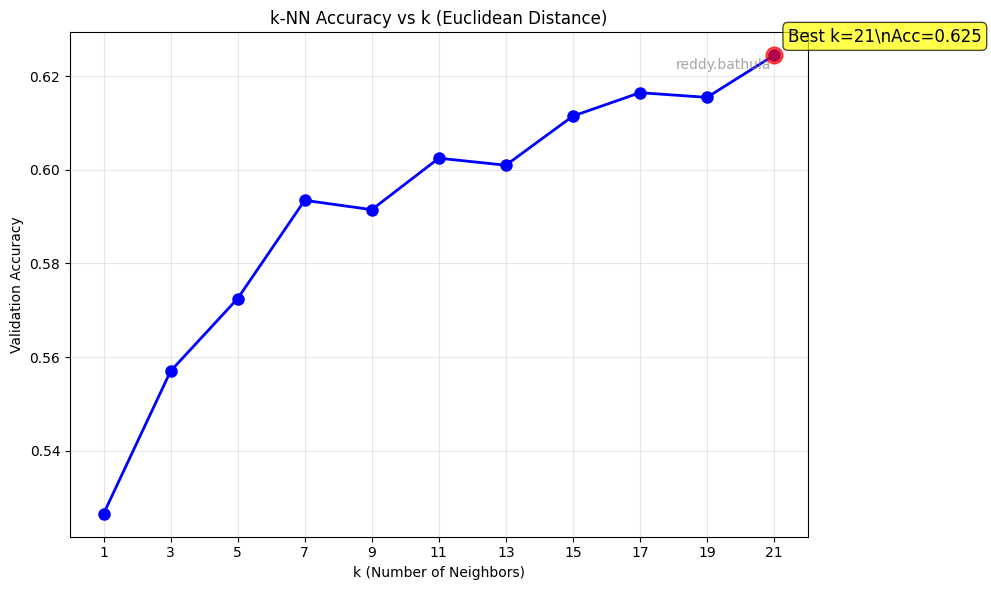

Best k for euclidean: 21 with accuracy: 0.6245

--- Manhattan Distance ---


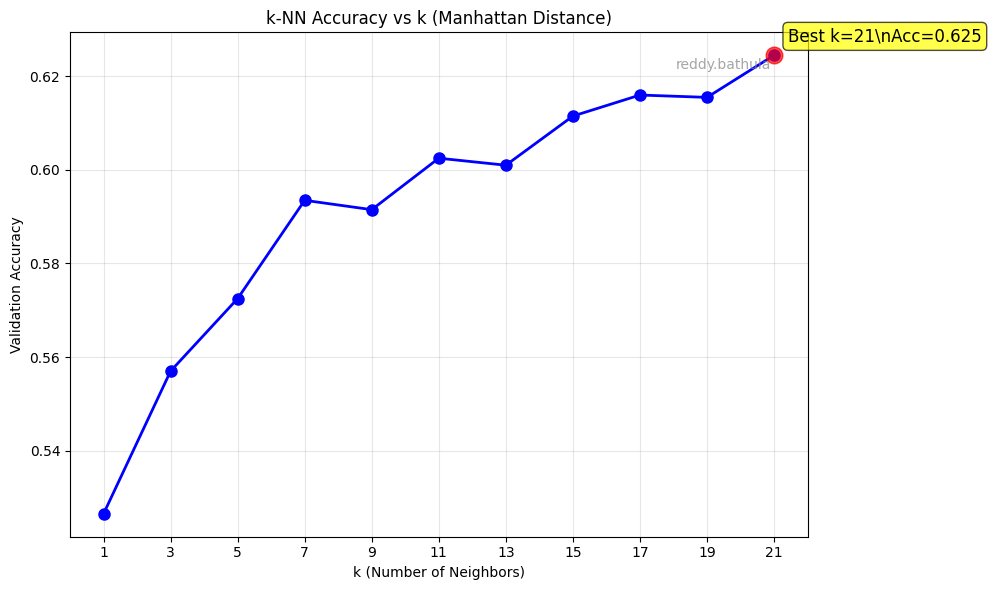

Best k for manhattan: 21 with accuracy: 0.6245

--- Cosine Distance ---


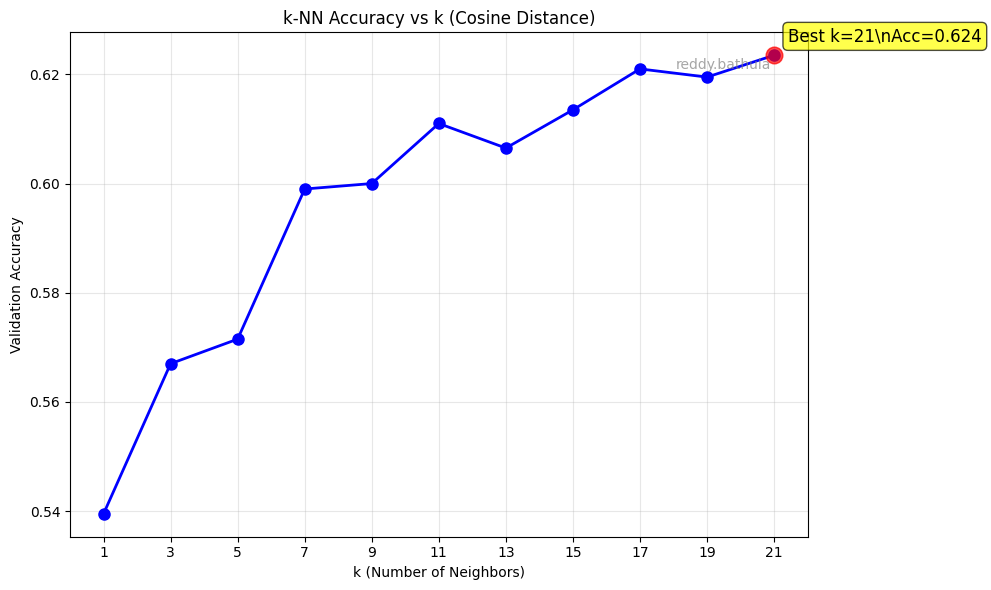

Best k for cosine: 21 with accuracy: 0.6235

=== Summary of Best Results ===
Euclidean: k=21, accuracy=0.6245
Manhattan: k=21, accuracy=0.6245
Cosine: k=21, accuracy=0.6235


In [8]:
print("\n=== Accuracy Analysis for Different Distance Metrics ===")
k_values = list(range(1, 22, 2))
print(f"Testing k values: {k_values}")
distances = ['euclidean', 'manhattan', 'cosine']
best_results = {}

for distance in distances:
    print(f"\n--- {distance.capitalize()} Distance ---")
    best_k, best_acc = knn_predictor.plot_knn_accuracy_vs_k(k_values, distance)
    best_results[distance] = {'best_k': best_k, 'best_accuracy': best_acc}
    print(f"Best k for {distance}: {best_k} with accuracy: {best_acc:.4f}")

print("\n=== Summary of Best Results ===")
for distance, results in best_results.items():
    print(f"{distance.capitalize()}: k={results['best_k']}, accuracy={results['best_accuracy']:.4f}")

- K=21 gave the highest accuracy with Euclidean distance


=== F1 Score Heatmap Analysis ===
F1 Scores for all k and distance combinations:
               1       3       5       7       9       11      13      15  \
euclidean  0.5230  0.5387  0.5412  0.5483  0.5352  0.5375  0.5304  0.5339   
manhattan  0.5230  0.5387  0.5412  0.5483  0.5352  0.5375  0.5304  0.5339   
cosine     0.5303  0.5443  0.5430  0.5502  0.5391  0.5407  0.5313  0.5341   

               17      19      21  
euclidean  0.5332  0.5248  0.5283  
manhattan  0.5329  0.5248  0.5283  
cosine     0.5353  0.5278  0.5242  


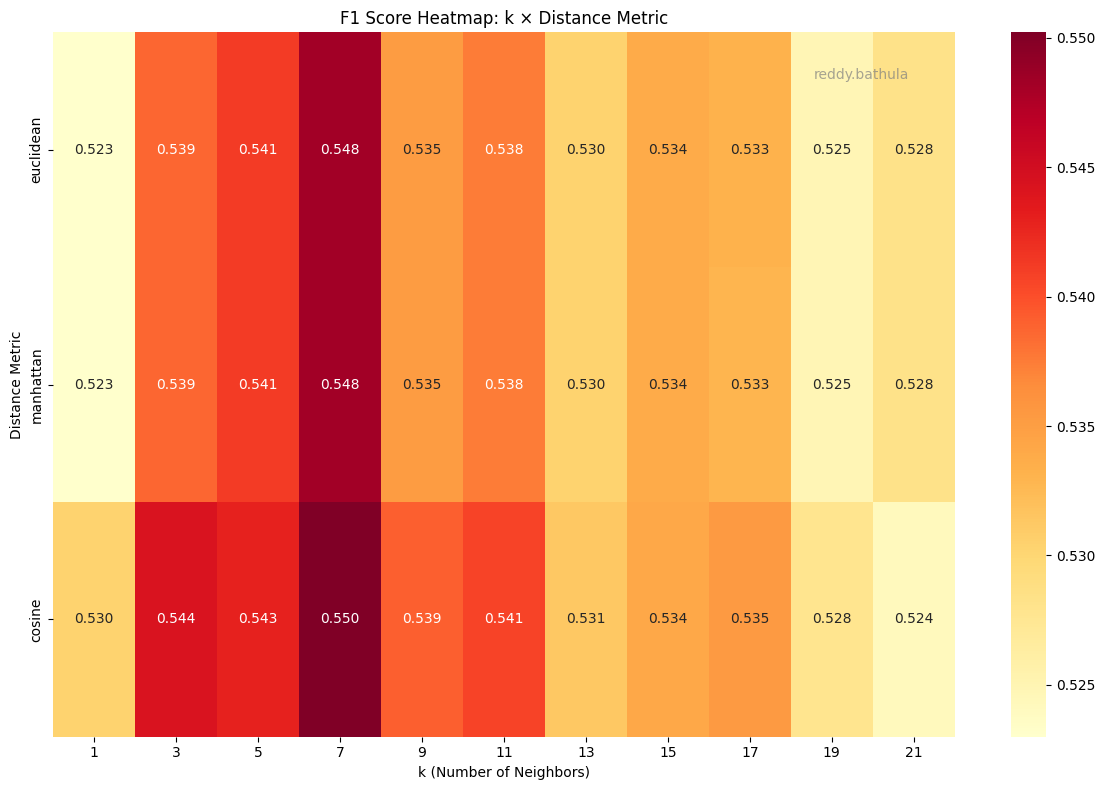


Best F1 Score: 0.5502
Best combination: k=7, distance=cosine

Average F1 scores by distance metric:
Euclidean: 0.5340
Manhattan: 0.5340
Cosine: 0.5364

Best performing distance metric overall: Cosine


In [9]:
print("\n=== F1 Score Heatmap Analysis ===")
f1_scores_df = knn_predictor.get_knn_f1_heatmap(k_values, distances)
print("F1 Scores for all k and distance combinations:")
print(f1_scores_df.round(4))
knn_predictor.plot_knn_f1_heatmap(f1_scores_df)
best_f1_overall = f1_scores_df.max().max()
best_position = f1_scores_df.stack().idxmax()
best_distance, best_k_f1 = best_position

print(f"\nBest F1 Score: {best_f1_overall:.4f}")
print(f"Best combination: k={best_k_f1}, distance={best_distance}")

distance_avg_f1 = f1_scores_df.mean(axis=1)
print(f"\nAverage F1 scores by distance metric:")
for distance, avg_f1 in distance_avg_f1.items():
    print(f"{distance.capitalize()}: {avg_f1:.4f}")

best_distance_overall = distance_avg_f1.idxmax()
print(f"\nBest performing distance metric overall: {best_distance_overall.capitalize()}")


=== Single Feature Analysis ===

--- Single Feature F1 Scores (Euclidean Distance) ---
F1 Scores on Test Set:
Best single feature: GPA with k=7, F1=0.5727


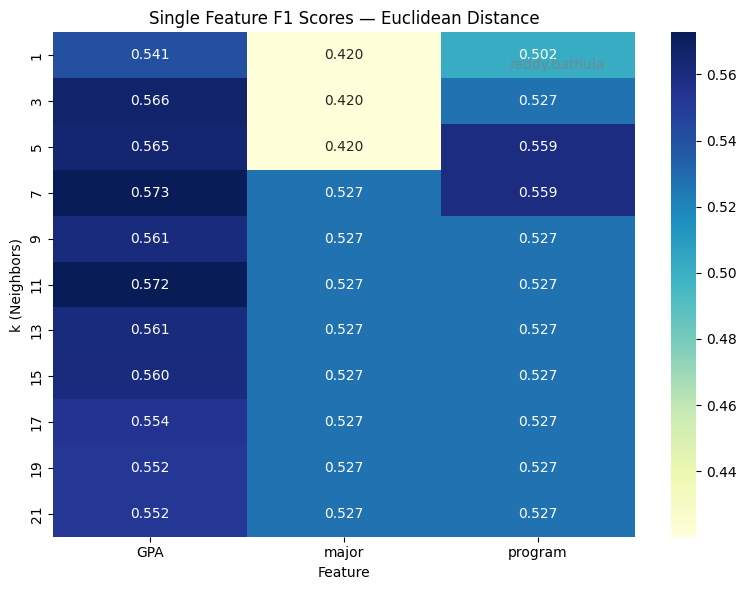


--- Single Feature F1 Scores (Manhattan Distance) ---
F1 Scores on Test Set:
Best single feature: GPA with k=7, F1=0.5727


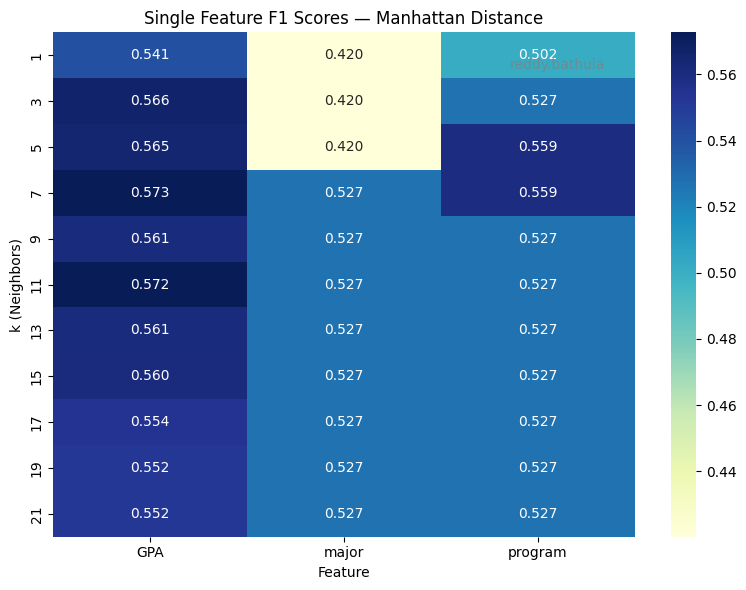


--- Single Feature F1 Scores (Cosine Distance) ---
F1 Scores on Test Set:
Best single feature: program with k=9, F1=0.5591


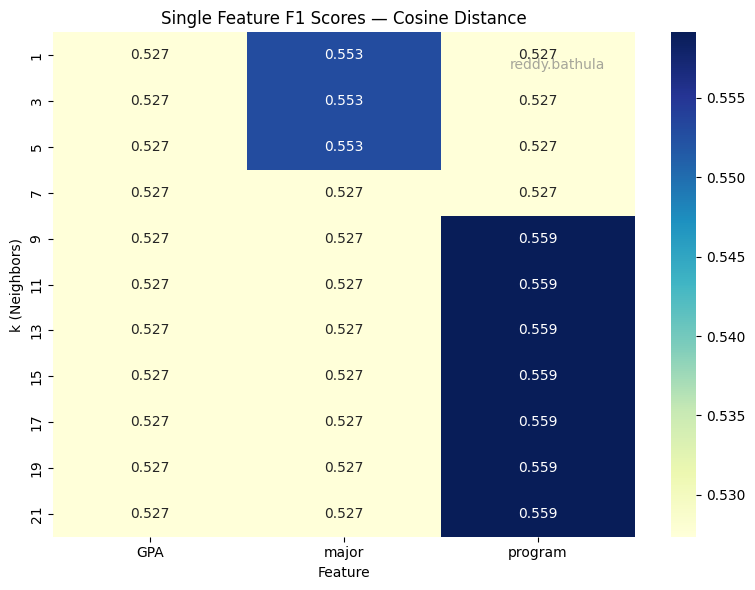


=== Comparison: Single Features vs All Features ===
Euclidean - All features (k=21): F1=0.5522
Manhattan - All features (k=21): F1=0.5522
Cosine - All features (k=21): F1=0.5494


In [10]:
print("\n=== Single Feature Analysis ===")
features_to_test = ['GPA', 'major', 'program']
for distance in distances:
    print(f"\n--- Single Feature F1 Scores ({distance.capitalize()} Distance) ---")
    single_feature_f1 = knn_predictor.get_knn_f1_single_feature_table(k_values, features_to_test, distance)
    print(f"F1 Scores on Test Set:")
    best_single_f1 = single_feature_f1.max().max()
    best_single_position = single_feature_f1.stack().idxmax()
    best_single_k, best_single_feature = best_single_position
    print(f"Best single feature: {best_single_feature} with k={best_single_k}, F1={best_single_f1:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(single_feature_f1, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f"Single Feature F1 Scores — {distance.capitalize()} Distance")
    plt.xlabel("Feature")
    plt.ylabel("k (Neighbors)")
    plt.tight_layout()
    knn_predictor._watermark(plt.gca())
    plt.show()

print("\n=== Comparison: Single Features vs All Features ===")

X_train, y_train = knn_predictor.get_feature_matrix_and_labels(knn_predictor.train_df, ['GPA', 'major', 'program'])
X_test, y_test = knn_predictor.get_feature_matrix_and_labels(knn_predictor.test_df, ['GPA', 'major', 'program'])

all_features_results = {}
for distance in distances:
    best_k_for_distance = best_results[distance]['best_k']
    knn = KNeighborsClassifier(n_neighbors=best_k_for_distance, metric=distance)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    all_features_f1 = f1_score(y_test, y_pred, average='weighted')
    all_features_results[distance] = all_features_f1
    
    print(f"{distance.capitalize()} - All features (k={best_k_for_distance}): F1={all_features_f1:.4f}")


- Overall, GPA performed slightly better, compared to other features and all features combined as well. 
- The continous nature of this feature influences the predictions. Distances between categorical features is always equal for different categories, while it only changes with GPA.